# Imports

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import tree 
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as pyplot
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_fscore_support

from warnings import simplefilter
import time
start = time.time()

In [68]:
dftrain = pd.read_csv("train70.csv", low_memory=False) 
dftest = pd.read_csv("test30.csv", low_memory=False)
simplefilter(action='ignore', category=FutureWarning)
seed = 7

In [69]:
class_names = dftrain.target.unique()
dftrain=dftrain.astype('category')
cat_columns = dftrain.select_dtypes(['category']).columns
dftrain[cat_columns] = dftrain[cat_columns].apply(lambda x: x.cat.codes)
x_columns = dftrain.columns.drop('target')
x_train = dftrain[x_columns].values
y_train = dftrain['target']

class_names = dftest.target.unique()
dftest=dftest.astype('category')
cat_columns = dftest.select_dtypes(['category']).columns
dftest[cat_columns] = dftest[cat_columns].apply(lambda x: x.cat.codes)
x_columns = dftest.columns.drop('target')
x_test = dftest[x_columns].values
y_test = dftest['target']

## DNN

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [26]:
# Get X tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
X_test_tensor = torch.tensor(x_test, dtype=torch.float32)

# Get y tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Load training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=1000)

# Load testing
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000)

In [27]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [28]:
class DNNMulticlass(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(33, 50) # 33 features => X_train.shape[1]
        self.layer2 = nn.Linear(50, 30)
        self.layer3 = nn.Linear(30, 20)
        self.out_layer = nn.Linear(20, 6) # 6 classifications =>  y_train.value_counts()

    def forward(self, x):
        x = F.leaky_relu(self.layer1(x), negative_slope=0.05)
        x = F.leaky_relu(self.layer2(x), negative_slope=0.05)
        x = F.leaky_relu(self.layer3(x), negative_slope=0.05)
        x = self.out_layer(x) 
        return x
    

In [30]:
# Training script

model_dnn = DNNMulticlass()
early_stopping = EarlyStopping(patience=10, delta=0.001) # If model doesn't improve by 0.001 in "patience" steps, end training 

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model_dnn.parameters(), lr=0.001)

training_losses = []
validation_losses = []

epochs = 10
for epoch in range(epochs): 
    model_dnn.train()
    train_loss = 0.0
    for inputs, labels in train_loader:

        optimizer.zero_grad()

        # Feed forward + backpropogate
        outputs = model_dnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)

    # Validation
    model_dnn.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in test_loader:
            outputs = model_dnn(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        # Average validation loss for this epoch
        avg_val_loss = val_loss / len(test_loader)
        validation_losses.append(avg_val_loss)

    print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print('Finished Training')

Epoch [1/10], Training Loss: 0.0460, Validation Loss: 0.0576
Epoch [2/10], Training Loss: 0.0202, Validation Loss: 0.0652
Epoch [3/10], Training Loss: 0.0156, Validation Loss: 0.0625
Epoch [4/10], Training Loss: 0.0143, Validation Loss: 0.0599
Epoch [5/10], Training Loss: 0.0137, Validation Loss: 0.0605
Epoch [6/10], Training Loss: 0.0134, Validation Loss: 0.0604
Epoch [7/10], Training Loss: 0.0131, Validation Loss: 0.0604
Epoch [8/10], Training Loss: 0.0129, Validation Loss: 0.0589
Epoch [9/10], Training Loss: 0.0129, Validation Loss: 0.0546
Epoch [10/10], Training Loss: 0.0128, Validation Loss: 0.0547
Finished Training


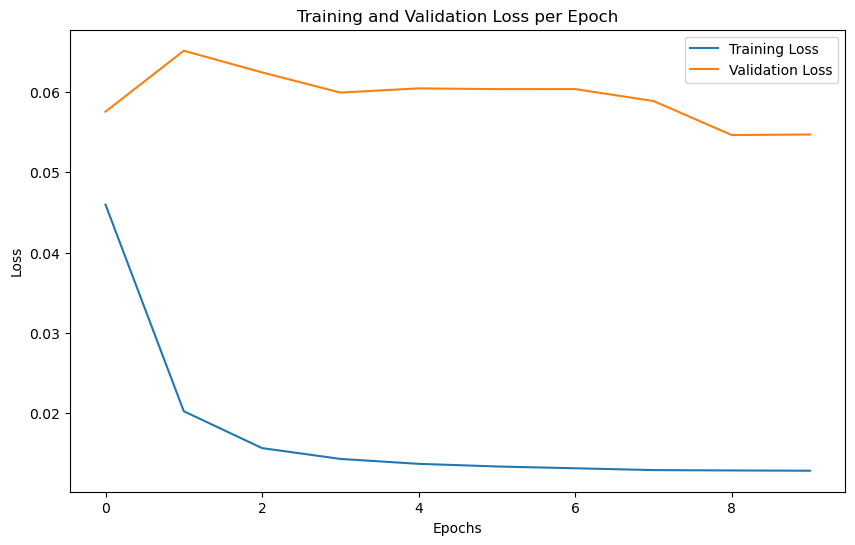

In [31]:
# Get the training and validation graphs

plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
# Evaluations
model_dnn.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_dnn(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the index of the max logit
        all_predictions.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

conf_matrix = confusion_matrix(all_labels, all_predictions)

In [43]:
model_dnn.eval()

all_probabilities = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_dnn(inputs)
        probabilities = F.softmax(outputs, dim=1)
        all_probabilities.extend(probabilities.numpy())
        all_labels.extend(labels.numpy())

all_probabilities = np.array(all_probabilities)
all_labels = np.array(all_labels)

classes = np.arange(6)  # 6 classes
y_test_binarized = label_binarize(all_labels, classes=classes)

auc = roc_auc_score(y_test_binarized, all_probabilities, multi_class='ovr')

print(f"AUC (One-vs-Rest): {auc:.2f}")

AUC (One-vs-Rest): 0.97


In [51]:
auc = roc_auc_score(y_test_binarized, all_probabilities, multi_class='ovr', average='weighted')
print(auc)

0.9695215986106736


In [57]:
auc = roc_auc_score(y_test_binarized, all_probabilities, multi_class='ovr', average='micro')
print(auc)

0.9997075410520507


In [59]:
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='micro')
recall = recall_score(all_labels, all_predictions, average='micro')
f1 = f1_score(all_labels, all_predictions, average='micro')

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.9964029570964963
Precision: 0.9964029570964963
Recall: 0.9964029570964963
F1 Score: 0.9964029570964963


In [54]:
num_classes = 6
weighted_TPR, weighted_FPR, weighted_FNR, weighted_TNR = 0, 0, 0, 0
total_instances = np.sum(conf_matrix)

for i in range(num_classes):
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP
    TN = np.sum(conf_matrix) - TP - FP - FN

    TPR = TP / (TP + FN) if TP + FN > 0 else 0
    FPR = FP / (FP + TN) if FP + TN > 0 else 0
    FNR = FN / (FN + TP) if FN + TP > 0 else 0
    TNR = TN / (TN + FP) if TN + FP > 0 else 0

    class_weight = np.sum(conf_matrix[i, :]) / total_instances

    weighted_TPR += TPR * class_weight
    weighted_FPR += FPR * class_weight
    weighted_FNR += FNR * class_weight
    weighted_TNR += TNR * class_weight

weighted_metrics = {
    "Weighted True Positive Rate (TPR)": round(weighted_TPR, 4),
    "Weighted False Positive Rate (FPR)": round(weighted_FPR, 4),
    "Weighted False Negative Rate (FNR)": round(weighted_FNR, 4),
    "Weighted True Negative Rate (TNR)": round(weighted_TNR, 4)
}

weighted_metrics

{'Weighted True Positive Rate (TPR)': 0.9964,
 'Weighted False Positive Rate (FPR)': 0.1318,
 'Weighted False Negative Rate (FNR)': 0.0036,
 'Weighted True Negative Rate (TNR)': 0.8682}

In [56]:
num_classes = 6
total_TPR, total_FPR, total_FNR, total_TNR = 0, 0, 0, 0

for i in range(num_classes):
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP
    TN = np.sum(conf_matrix) - TP - FP - FN

    TPR = TP / (TP + FN) if TP + FN > 0 else 0
    FPR = FP / (FP + TN) if FP + TN > 0 else 0
    FNR = FN / (FN + TP) if FN + TP > 0 else 0
    TNR = TN / (TN + FP) if TN + FP > 0 else 0

    total_TPR += TPR
    total_FPR += FPR
    total_FNR += FNR
    total_TNR += TNR

macro_TPR = total_TPR / num_classes
macro_FPR = total_FPR / num_classes
macro_FNR = total_FNR / num_classes
macro_TNR = total_TNR / num_classes

macro_metrics = {
    "Macro True Positive Rate (TPR)": round(macro_TPR, 4),
    "Macro False Positive Rate (FPR)": round(macro_FPR, 4),
    "Macro False Negative Rate (FNR)": round(macro_FNR, 4),
    "Macro True Negative Rate (TNR)": round(macro_TNR, 4)
}

macro_metrics

{'Macro True Positive Rate (TPR)': 0.7516,
 'Macro False Positive Rate (FPR)': 0.0226,
 'Macro False Negative Rate (FNR)': 0.2484,
 'Macro True Negative Rate (TNR)': 0.9774}

In [58]:
num_classes = 6
total_TP, total_FP, total_FN, total_TN = 0, 0, 0, 0

for i in range(num_classes):
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP
    TN = np.sum(conf_matrix) - TP - FP - FN

    total_TP += TP
    total_FP += FP
    total_FN += FN
    total_TN += TN

micro_TPR = total_TP / (total_TP + total_FN) if total_TP + total_FN > 0 else 0
micro_FPR = total_FP / (total_FP + total_TN) if total_FP + total_TN > 0 else 0
micro_FNR = total_FN / (total_FN + total_TP) if total_FN + total_TP > 0 else 0
micro_TNR = total_TN / (total_TN + total_FP) if total_TN + total_FP > 0 else 0

micro_metrics = {
    "Micro True Positive Rate (TPR)": round(micro_TPR, 4),
    "Micro False Positive Rate (FPR)": round(micro_FPR, 4),
    "Micro False Negative Rate (FNR)": round(micro_FNR, 4),
    "Micro True Negative Rate (TNR)": round(micro_TNR, 4)
}

micro_metrics

{'Micro True Positive Rate (TPR)': 0.9964,
 'Micro False Positive Rate (FPR)': 0.0007,
 'Micro False Negative Rate (FNR)': 0.0036,
 'Micro True Negative Rate (TNR)': 0.9993}

## CNN

In [60]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import SGD

In [61]:
x_train

array([[    6,   142,    11, ...,     0,     0,     0],
       [    6, 11039,    11, ...,     0,     0,     0],
       [    2,     8,     0, ...,     0,     0,     0],
       ...,
       [    2,     8,     0, ...,     0,     0,     0],
       [    6,    10,    11, ...,     0,     0,     0],
       [    2,     4,     0, ...,     0,     0,     0]], dtype=int32)

In [62]:
x_test

array([[   6, 7185,    7, ...,    0,    0,    0],
       [   6, 8387,   10, ...,    0,    0,    0],
       [   6,  157,    7, ...,    0,    0,    0],
       ...,
       [   6,    5,   10, ...,    0,    0,    0],
       [   6,  103,   10, ...,    0,    0,    0],
       [   6,   10,   10, ...,    0,    0,    0]], dtype=int16)

In [70]:
### Reshape training and test data for CNN model training
x_train_cnn = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test_cnn = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
input_shape = x_train_cnn.shape[1:]

y_train_cnn = np.array(y_train)
num_classes = len(np.unique(y_train))

In [120]:
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=20, kernel_size=4, strides=2, padding='valid', activation='relu', input_shape=input_shape))
cnn_model.add(MaxPooling1D())
cnn_model.add(Conv1D(filters=20, kernel_size=4, strides=2, padding='same', activation='relu'))
cnn_model.add(Conv1D(filters=3, kernel_size=2, strides=1, padding='same', activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=100, activation='relu'))
cnn_model.add(Dense(units=50, activation='relu'))
cnn_model.add(Dense(units=30, activation='relu'))
cnn_model.add(Dense(units=20, activation='relu'))
cnn_model.add(Dense(units=num_classes, activation='softmax'))

opt = SGD(learning_rate=0.001) 
cnn_model.compile(loss = "sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [121]:
hist = cnn_model.fit(x_train, y_train, epochs=10,
                       batch_size=1000, validation_split=0.2,
                       callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)])

Epoch 1/10
6766/6766 [==============================] - 153s 22ms/step - loss: 0.2027 - accuracy: 0.9929 - val_loss: 0.1551 - val_accuracy: 0.9688
Epoch 2/10
6766/6766 [==============================] - 164s 24ms/step - loss: 0.0512 - accuracy: 0.9938 - val_loss: 0.0482 - val_accuracy: 0.9939
Epoch 3/10
6766/6766 [==============================] - 175s 26ms/step - loss: 0.0481 - accuracy: 0.9939 - val_loss: 0.0463 - val_accuracy: 0.9940
Epoch 4/10
6766/6766 [==============================] - 352s 52ms/step - loss: 0.0469 - accuracy: 0.9939 - val_loss: 0.0462 - val_accuracy: 0.9940
Epoch 5/10
6766/6766 [==============================] - 145s 21ms/step - loss: 0.0458 - accuracy: 0.9939 - val_loss: 0.0449 - val_accuracy: 0.9940
Epoch 6/10
6766/6766 [==============================] - 158s 23ms/step - loss: 0.0450 - accuracy: 0.9939 - val_loss: 0.0437 - val_accuracy: 0.9940
Epoch 7/10
6766/6766 [==============================] - 151s 22ms/step - loss: 0.0442 - accuracy: 0.9939 - val_loss: 0

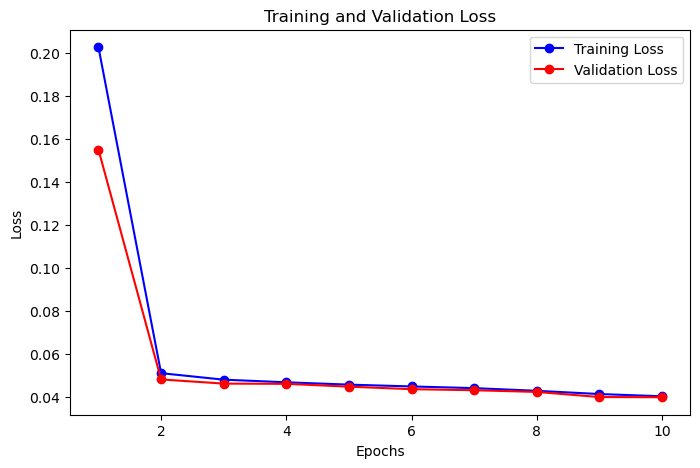

In [122]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [123]:
y_pred_probs = cnn_model.predict(x_test)


113262/113262 [==============================] - 169s 1ms/step


In [108]:
y_pred_probs

array([[3.56696721e-04, 1.27647037e-03, 1.25250197e-04, 9.97684002e-01,
        2.89653806e-04, 2.67946773e-04],
       [4.64322511e-05, 2.01809671e-04, 1.11731952e-05, 9.99675632e-01,
        3.92713628e-05, 2.57839129e-05],
       [1.16304145e-04, 9.74070630e-04, 3.18301572e-05, 9.97052193e-01,
        1.82323856e-03, 2.45624847e-06],
       ...,
       [1.01470425e-04, 9.22890496e-04, 2.34731524e-05, 9.97199535e-01,
        1.75068132e-03, 1.86520197e-06],
       [1.44444362e-04, 6.80928526e-04, 5.25187352e-05, 9.98894274e-01,
        1.25193139e-04, 1.02689592e-04],
       [1.57016402e-04, 7.22041645e-04, 5.62560963e-05, 9.98818815e-01,
        1.36438117e-04, 1.09422093e-04]], dtype=float32)

In [124]:
y_pred = np.argmax(y_pred_probs, axis=-1)

In [117]:
np.unique(y_pred)

array([1, 3, 4], dtype=int64)

In [125]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [132]:
num_classes = y_pred_probs.shape[1]
y_test_binarized = label_binarize(y_test, classes=range(num_classes))

auc_scores = []
for i in range(num_classes):
    auc_score = roc_auc_score(y_test_binarized[:, i], y_pred_probs[:, i])
    auc_scores.append(auc_score)

macro_auc = np.mean(auc_scores)
print("Macro-average AUC:", macro_auc)

Macro-average AUC: 0.8908673224587403


In [135]:
class_support = np.sum(y_test_binarized, axis=0)

weighted_auc = 0
total_instances = len(y_test)
for i in range(num_classes):
    class_weight = class_support[i] / total_instances
    auc_score = roc_auc_score(y_test_binarized[:, i], y_pred_probs[:, i])
    weighted_auc += auc_score * class_weight

print("Weighted-average AUC:", weighted_auc)

Weighted-average AUC: 0.9677888539370741


In [136]:
y_test_flat = y_test_binarized.ravel()
y_pred_probs_flat = y_pred_probs.ravel()

# Calculate the micro-average AUC
micro_auc = roc_auc_score(y_test_flat, y_pred_probs_flat)

print("Micro-average AUC:", micro_auc)

Micro-average AUC: 0.9992057671536149


In [126]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)

print(f"Macro Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1 Score: {f1_score:.4f}")

Macro Accuracy: 0.9940
Macro Precision: 0.3323
Macro Recall: 0.2853
Macro F1 Score: 0.3048


C:\Users\Elvin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [127]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')
accuracy = accuracy_score(y_test, y_pred)

print(f"Micro Accuracy: {accuracy:.4f}")
print(f"Micro Precision: {precision:.4f}")
print(f"Micro Recall: {recall:.4f}")
print(f"Micro F1 Score: {f1_score:.4f}")

Micro Accuracy: 0.9940
Micro Precision: 0.9940
Micro Recall: 0.9940
Micro F1 Score: 0.9940


In [128]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Weighted Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1 Score: {f1_score:.4f}")

Weighted Accuracy: 0.9940
Weighted Precision: 0.9911
Weighted Recall: 0.9940
Weighted F1 Score: 0.9923


C:\Users\Elvin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [129]:
num_classes = 6
weighted_TPR, weighted_FPR, weighted_FNR, weighted_TNR = 0, 0, 0, 0
total_instances = np.sum(conf_matrix)

for i in range(num_classes):
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP
    TN = np.sum(conf_matrix) - TP - FP - FN

    TPR = TP / (TP + FN) if TP + FN > 0 else 0
    FPR = FP / (FP + TN) if FP + TN > 0 else 0
    FNR = FN / (FN + TP) if FN + TP > 0 else 0
    TNR = TN / (TN + FP) if TN + FP > 0 else 0

    class_weight = np.sum(conf_matrix[i, :]) / total_instances

    weighted_TPR += TPR * class_weight
    weighted_FPR += FPR * class_weight
    weighted_FNR += FNR * class_weight
    weighted_TNR += TNR * class_weight

weighted_metrics = {
    "Weighted True Positive Rate (TPR)": round(weighted_TPR, 4),
    "Weighted False Positive Rate (FPR)": round(weighted_FPR, 4),
    "Weighted False Negative Rate (FNR)": round(weighted_FNR, 4),
    "Weighted True Negative Rate (TNR)": round(weighted_TNR, 4)
}

weighted_metrics

{'Weighted True Positive Rate (TPR)': 0.994,
 'Weighted False Positive Rate (FPR)': 0.4337,
 'Weighted False Negative Rate (FNR)': 0.006,
 'Weighted True Negative Rate (TNR)': 0.5663}

In [130]:
num_classes = 6
total_TPR, total_FPR, total_FNR, total_TNR = 0, 0, 0, 0

for i in range(num_classes):
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP
    TN = np.sum(conf_matrix) - TP - FP - FN

    TPR = TP / (TP + FN) if TP + FN > 0 else 0
    FPR = FP / (FP + TN) if FP + TN > 0 else 0
    FNR = FN / (FN + TP) if FN + TP > 0 else 0
    TNR = TN / (TN + FP) if TN + FP > 0 else 0

    total_TPR += TPR
    total_FPR += FPR
    total_FNR += FNR
    total_TNR += TNR

macro_TPR = total_TPR / num_classes
macro_FPR = total_FPR / num_classes
macro_FNR = total_FNR / num_classes
macro_TNR = total_TNR / num_classes

macro_metrics = {
    "Macro True Positive Rate (TPR)": round(macro_TPR, 4),
    "Macro False Positive Rate (FPR)": round(macro_FPR, 4),
    "Macro False Negative Rate (FNR)": round(macro_FNR, 4),
    "Macro True Negative Rate (TNR)": round(macro_TNR, 4)
}

macro_metrics

{'Macro True Positive Rate (TPR)': 0.2853,
 'Macro False Positive Rate (FPR)': 0.0733,
 'Macro False Negative Rate (FNR)': 0.7147,
 'Macro True Negative Rate (TNR)': 0.9267}

In [131]:
num_classes = 6
total_TP, total_FP, total_FN, total_TN = 0, 0, 0, 0

for i in range(num_classes):
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP
    TN = np.sum(conf_matrix) - TP - FP - FN

    total_TP += TP
    total_FP += FP
    total_FN += FN
    total_TN += TN

micro_TPR = total_TP / (total_TP + total_FN) if total_TP + total_FN > 0 else 0
micro_FPR = total_FP / (total_FP + total_TN) if total_FP + total_TN > 0 else 0
micro_FNR = total_FN / (total_FN + total_TP) if total_FN + total_TP > 0 else 0
micro_TNR = total_TN / (total_TN + total_FP) if total_TN + total_FP > 0 else 0

micro_metrics = {
    "Micro True Positive Rate (TPR)": round(micro_TPR, 4),
    "Micro False Positive Rate (FPR)": round(micro_FPR, 4),
    "Micro False Negative Rate (FNR)": round(micro_FNR, 4),
    "Micro True Negative Rate (TNR)": round(micro_TNR, 4)
}

micro_metrics

{'Micro True Positive Rate (TPR)': 0.994,
 'Micro False Positive Rate (FPR)': 0.0012,
 'Micro False Negative Rate (FNR)': 0.006,
 'Micro True Negative Rate (TNR)': 0.9988}

## RNN

In [141]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [138]:
num_features = 33
num_classes = 6  # Number of classes

class RNNTabularMulticlass(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNTabularMulticlass, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=3, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the output of the last time step
        return out

In [143]:
# Get X tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
X_test_tensor = torch.tensor(x_test, dtype=torch.float32)

# Get y tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Load training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=2000)

# Load testing
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=2000)

In [146]:
input_size = num_features
hidden_size = 100
output_size = num_classes  # Multiclass classification
model_rnn = RNNTabularMulticlass(input_size, hidden_size, output_size)

early_stopping = EarlyStopping(5, 0.0001)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_rnn.parameters(), lr=0.001)

epochs = 10
training_losses = []
validation_losses = [] 

for epoch in range(epochs):
    model_rnn.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model_rnn(inputs.unsqueeze(1))  # Reshape input
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)

    # Validation
    model_rnn.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in test_loader:
            outputs = model_rnn(inputs.unsqueeze(1))  # Reshape input
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()

        avg_val_loss = val_loss / len(test_loader)
        validation_losses.append(avg_val_loss)

    print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    # Implement early stopping
    if early_stopping is None:
        early_stopping = EarlyStopping(patience=5, delta=0.0001)
    
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print('Finished Training')


Epoch [1/10], Training Loss: 0.0340, Validation Loss: 0.0537
Epoch [2/10], Training Loss: 0.0232, Validation Loss: 0.0572
Epoch [3/10], Training Loss: 0.0193, Validation Loss: 0.0632
Epoch [4/10], Training Loss: 0.0182, Validation Loss: 0.0818
Epoch [5/10], Training Loss: 0.0189, Validation Loss: 0.0692
Epoch [6/10], Training Loss: 0.0190, Validation Loss: 0.0480
Epoch [7/10], Training Loss: 0.0191, Validation Loss: 0.0536
Epoch [8/10], Training Loss: 0.0182, Validation Loss: 0.0738
Epoch [9/10], Training Loss: 0.0170, Validation Loss: 0.0627
Epoch [10/10], Training Loss: 0.0177, Validation Loss: 0.0556
Finished Training


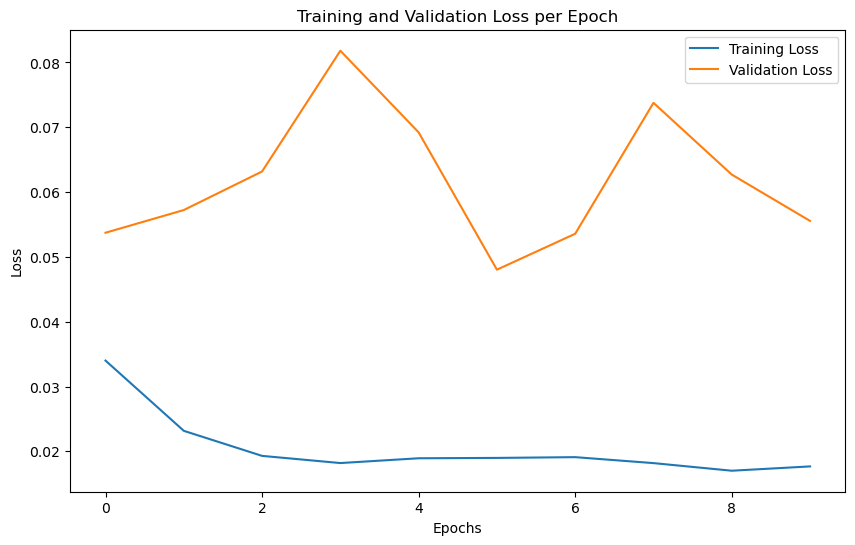

In [147]:
# Get the training and validation graphs

plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [148]:
# Evaluations
model_rnn.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    test_outputs = model_rnn(X_test_tensor.unsqueeze(1))
    predicted_probs = torch.softmax(test_outputs, dim=1).numpy()
    predicted_labels = torch.argmax(test_outputs.squeeze(), dim=1).numpy()

conf_matrix = confusion_matrix(y_test_tensor.numpy(), predicted_labels)

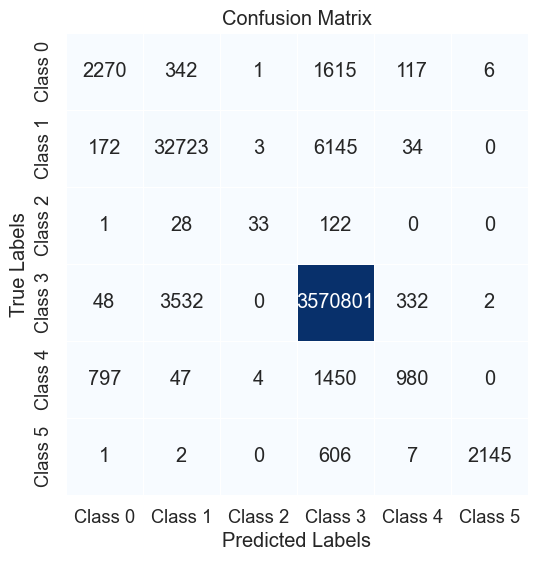

In [149]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5, square=True, cbar=False,
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [150]:
accuracy = accuracy_score(y_test_tensor.numpy(), predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_tensor.numpy(), predicted_labels, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Macro Precision: {precision:.4f}')
print(f'Macro Recall: {recall:.4f}')
print(f'Macro F1 Score: {f1:.4f}')

Accuracy: 0.9957
Macro Precision: 0.8412
Macro Recall: 0.6022
Macro F1 Score: 0.6726


In [151]:
accuracy = accuracy_score(y_test_tensor.numpy(), predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_tensor.numpy(), predicted_labels, average='micro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Micro Precision: {precision:.4f}')
print(f'Micro Recall: {recall:.4f}')
print(f'Micro F1 Score: {f1:.4f}')

Accuracy: 0.9957
Micro Precision: 0.9957
Micro Recall: 0.9957
Micro F1 Score: 0.9957


In [152]:
accuracy = accuracy_score(y_test_tensor.numpy(), predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_tensor.numpy(), predicted_labels, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Macro Precision: {precision:.4f}')
print(f'Macro Recall: {recall:.4f}')
print(f'Macro F1 Score: {f1:.4f}')

Accuracy: 0.9957
Macro Precision: 0.9954
Macro Recall: 0.9957
Macro F1 Score: 0.9955


In [153]:
roc_auc = roc_auc_score(y_test_tensor.numpy(), predicted_probs, average='macro', multi_class='ovr')
print(roc_auc)

0.9494115245977076


In [154]:
roc_auc = roc_auc_score(y_test_tensor.numpy(), predicted_probs, average='micro', multi_class='ovr')
print(roc_auc)

0.9997487540762712


In [155]:
roc_auc = roc_auc_score(y_test_tensor.numpy(), predicted_probs, average='weighted', multi_class='ovr')
print(roc_auc)

0.9719165780624988


In [156]:
class_labels = list(range(num_classes))
tpr = []
fpr = []
tnr = []
fnr = []

for i in class_labels:
    tp = conf_matrix[i, i]
    fp = conf_matrix[:, i].sum() - tp
    tn = conf_matrix.sum() - (fp + conf_matrix[i, :].sum())
    fn = conf_matrix[i, :].sum() - tp

    tpr_i = tp / (tp + fn)
    fpr_i = fp / (fp + tn)
    tnr_i = tn / (tn + fp)  
    fnr_i = fn / (fn + tp)  

    tpr.append(tpr_i)
    fpr.append(fpr_i)
    tnr.append(tnr_i)
    fnr.append(fnr_i)

macro_avg_tpr = sum(tpr) / len(tpr)
macro_avg_fpr = sum(fpr) / len(fpr)
macro_avg_tnr = sum(tnr) / len(tnr)
macro_avg_fnr = sum(fnr) / len(fnr)

print(f'Macro-Average TPR: {macro_avg_tpr:.4f}')
print(f'Macro-Average FPR: {macro_avg_fpr:.4f}')
print(f'Macro-Average TNR: {macro_avg_tnr:.4f}')
print(f'Macro-Average FNR: {macro_avg_fnr:.4f}')

Macro-Average TPR: 0.6022
Macro-Average FPR: 0.0336
Macro-Average TNR: 0.9664
Macro-Average FNR: 0.3978


In [157]:
class_labels = list(range(num_classes))

tp_total = 0
fp_total = 0
tn_total = 0
fn_total = 0

for i in class_labels:
    tp = conf_matrix[i, i]
    fp = conf_matrix[:, i].sum() - tp
    tn = conf_matrix.sum() - (fp + conf_matrix[i, :].sum())
    fn = conf_matrix[i, :].sum() - tp

    # Aggregate counts
    tp_total += tp
    fp_total += fp
    tn_total += tn
    fn_total += fn

# Compute micro-average rates
micro_avg_tpr = tp_total / (tp_total + fn_total)
micro_avg_fpr = fp_total / (fp_total + tn_total)
micro_avg_tnr = tn_total / (tn_total + fp_total)
micro_avg_fnr = fn_total / (fn_total + tp_total)

print(f'Micro-Average TPR: {micro_avg_tpr:.4f}')
print(f'Micro-Average FPR: {micro_avg_fpr:.4f}')
print(f'Micro-Average TNR: {micro_avg_tnr:.4f}')
print(f'Micro-Average FNR: {micro_avg_fnr:.4f}')

Micro-Average TPR: 0.9957
Micro-Average FPR: 0.0009
Micro-Average TNR: 0.9991
Micro-Average FNR: 0.0043


In [158]:
class_labels = list(range(num_classes))

weighted_sum_tpr = 0
weighted_sum_fpr = 0
weighted_sum_tnr = 0
weighted_sum_fnr = 0

total_instances = conf_matrix.sum()

for i in class_labels:
    tp = conf_matrix[i, i]
    fp = conf_matrix[:, i].sum() - tp
    tn = conf_matrix.sum() - (fp + conf_matrix[i, :].sum())
    fn = conf_matrix[i, :].sum() - tp

    tpr_i = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr_i = fp / (fp + tn) if (fp + tn) > 0 else 0
    tnr_i = tn / (tn + fp) if (tn + fp) > 0 else 0
    fnr_i = fn / (fn + tp) if (fn + tp) > 0 else 0

    class_weight = (tp + fn) / total_instances

    weighted_sum_tpr += tpr_i * class_weight
    weighted_sum_fpr += fpr_i * class_weight
    weighted_sum_tnr += tnr_i * class_weight
    weighted_sum_fnr += fnr_i * class_weight

print(f'Weighted-Average TPR: {weighted_sum_tpr:.4f}')
print(f'Weighted-Average FPR: {weighted_sum_fpr:.4f}')
print(f'Weighted-Average TNR: {weighted_sum_tnr:.4f}')
print(f'Weighted-Average FNR: {weighted_sum_fnr:.4f}')

Weighted-Average TPR: 0.9957
Weighted-Average FPR: 0.1974
Weighted-Average TNR: 0.8026
Weighted-Average FNR: 0.0043
